In [1]:
import itertools, copy
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from lib import *

In [2]:
counters = [count_kmers_proteome(human, k) for k in range(1, 6)]

In [3]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
aas = ''.join(sorted(df0['seq']))
print(len(aas), aas)

20 ACDEFGHIKLMNPQRSTVWY


In [4]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
df0 = df0.set_index('seq')
humanaaprobdict = np.log(df0['freq']).to_dict()
humanaaprobdict

df1 = counter_to_df(counters[1], norm=False)
strcolumn_to_charcolumns(df1, 'seq')
count = df1.pivot(columns='aa1', index='aa2')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humandoubletprobdict = np.log(count).to_dict()

In [5]:
df2 = counter_to_df(counters[2], norm=False)
df2['aa12'] = [s[:2] for s in df2['seq']]
df2['aa3'] = [s[2] for s in df2['seq']]
count = df2.pivot(columns='aa12', index='aa3')['count']
count /= np.sum(count, axis=0)
count[count.isna()] = 1e-10
humantripletprobdict = np.log(count).to_dict()

In [6]:
h = copy.deepcopy(humanaaprobdict)
J0 = dict(zip(aminoacids, [dict(zip(aminoacids, np.zeros(len(aminoacids))))]*len(aminoacids)))
Jk = [J0, copy.deepcopy(J0)]

In [237]:
np.exp(-energy_ising('ACL', h, Jk))/Z

0.00014041409958366575

In [238]:
np.exp(loglikelihood_independent('ACL', humanaaprobdict))

0.0001606189778362446

In [239]:
np.exp(loglikelihood_mc('ACL', humanaaprobdict, humandoubletprobdict))

0.00013991001867381708

In [240]:
np.exp(loglikelihood_triplet('ACL', humanaaprobdict, humandoubletprobdict, humantripletprobdict))

0.0001452302456227127

In [12]:
aafreqs = np.array(df0.loc[np.array(list(aas))]['freq'])
aafreqs /= np.sum(aafreqs)

In [13]:
aas_arr = np.array(list(aminoacids))
def jump(x):
    i = np.random.randint(0, len(x))
    x = list(x)
    x[i] = np.random.choice(aas_arr)
    return ''.join(x)

In [14]:
df1 = counter_to_df(counters[1])
df1 = df1[~df1['seq'].str.contains('U|B|X|Z')]
df1 = df1.set_index('seq')

In [15]:
dfgap1 = counter_to_df(count_kmers_proteome(human, 2, gap=1))
dfgap1 = dfgap1[~dfgap1['seq'].str.contains('U|B|X|Z')]
dfgap1 = dfgap1.set_index('seq')

In [152]:
dfgap2 = counter_to_df(count_kmers_proteome(human, 2, gap=2))
dfgap2 = dfgap2[~dfgap2['seq'].str.contains('U|B|X|Z')]
dfgap2 = dfgap2.set_index('seq')

In [142]:
def fit_ising(f1, f2s, niter=1, nmcmc=1e6, epsilon=0.1, Jk=None):
    h = np.log(f1['freq']).to_dict()
    if Jk is None:
        J0 = np.zeros((len(aminoacids), len(aminoacids)))
        J0 = pd.DataFrame(np.asarray(J0), index=list(aminoacids), columns=list(aminoacids)).to_dict()
        Jk = [J0]
        for gap in range(1, len(f2s)):
            Jk.append(copy.deepcopy(J0))
    for i in range(niter):
        jump = lambda x: ''.join(np.random.choice(aas_arr, size=6))
        x0 = jump(None)
        samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, nmcmc)
        for gap in range(len(f2s)):
            m = f2s[gap].merge(counter_to_df(count_kmers_iterable(samples, 2, gap=gap)), left_index=True, right_on='seq')
            m['logfold'] = np.log(m['freq_x']/m['freq_y'])
            print(i, gap, np.mean(np.abs(m['logfold'])))
            for idx, row in m.iterrows():
                logfold = row['logfold']
                aa1 = row['seq'][0]
                aa2 = row['seq'][1]
                Jk[gap][aa1][aa2] += logfold * epsilon
    return h, Jk

In [187]:
h, Jk = fit_ising(df0, [df1, dfgap1, dfgap2], nmcmc=1e5, niter=30, epsilon=0.1)

0 0 0.11248253227092625
0 1 0.10123918693188423
0 2 0.1058880980755796
1 0 0.10586226081487213
1 1 0.09277145218947737
1 2 0.09408424797514192
2 0 0.09207271960443485
2 1 0.08635836725756199
2 2 0.09306114508050962
3 0 0.0951505127229145
3 1 0.08507016098547954
3 2 0.09417082558691174
4 0 0.08890687741762049
4 1 0.08696590920292518
4 2 0.0830177512184177
5 0 0.0804826455349062
5 1 0.07937368006559906
5 2 0.08662563121156987
6 0 0.07796754718572867
6 1 0.07440219920932621
6 2 0.08491420112445178
7 0 0.07589857104980602
7 1 0.0737718533274039
7 2 0.08000494907270948
8 0 0.06914055453231086
8 1 0.0715439381754393
8 2 0.07179327355558049
9 0 0.06858329259712413
9 1 0.06828798755810084
9 2 0.07618540018016401
10 0 0.06620993009758198
10 1 0.06194051679183981
10 2 0.07297778913599688
11 0 0.0606319912403882
11 1 0.06574706656868191
11 2 0.07116373456128831
12 0 0.06265138497471484
12 1 0.06751414563899708
12 2 0.0725399972308029
13 0 0.061406680122243
13 1 0.06473341294512722
13 2 0.06968820

In [188]:
jump = lambda x: ''.join(np.random.choice(aas_arr, size=6))
x0 = jump(0)
samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, 1e6)

0.008591739901784844

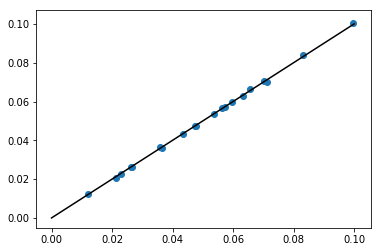

In [189]:
dfm0 = df0.merge(counter_to_df(count_kmers_iterable(samples, 1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.1)
plt.plot(x, x, 'k')
plt.scatter(dfm0['freq_x'], dfm0['freq_y'])
dfm0['logfold'] = np.log(dfm0['freq_x']/dfm0['freq_y'])
np.abs(dfm0['logfold']).mean()

0.02235338629643

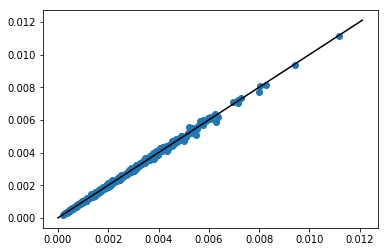

In [190]:
dfm1 = df1.merge(counter_to_df(count_kmers_iterable(samples, 2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfm1['freq_x'], dfm1['freq_y'])
dfm1['logfold'] = np.log(dfm1['freq_x']/dfm1['freq_y'])
np.abs(dfm1['logfold']).mean()

0.02457402669827191

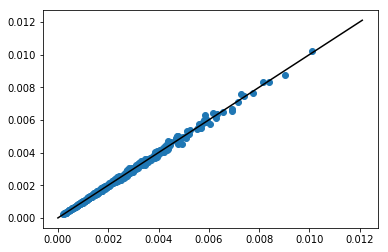

In [191]:
dfmgap1 = dfgap1.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap1['freq_x'], dfmgap1['freq_y'])
dfmgap1['logfold'] = np.log(dfmgap1['freq_x']/dfmgap1['freq_y'])
np.abs(dfmgap1['logfold']).mean()

0.029673292671147173

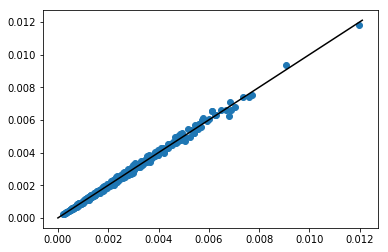

In [192]:
dfmgap2 = dfgap2.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap2['freq_x'], dfmgap2['freq_y'])
dfmgap2['logfold'] = np.log(dfmgap2['freq_x']/dfmgap2['freq_y'])
np.abs(dfmgap2['logfold']).mean()

In [209]:
dfJk = [pd.DataFrame.from_dict(J) for J in Jk]

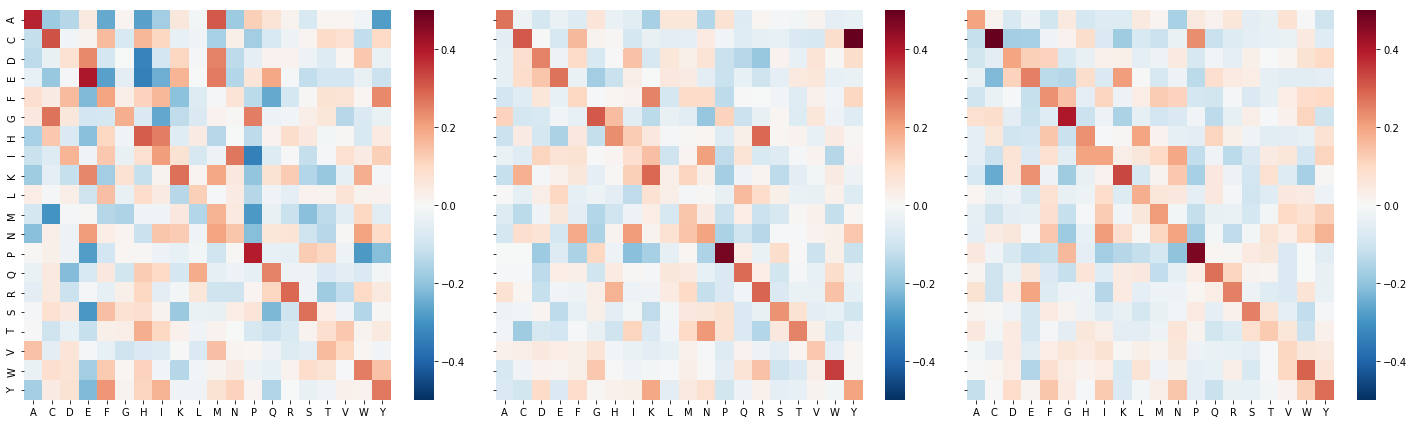

In [235]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=len(dfJk), sharex=True, sharey=True)
for i, dfJ in enumerate(dfJk):
    sns.heatmap(dfJ, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=axes[i])
fig.tight_layout()

In [334]:
k = 4
#kmers = list(itertools.product(aminoacids, repeat=k))
df = counter_to_df(count_kmers_proteome(human, k))
df = df[~df['seq'].str.contains('U|B|X|Z')]
df = df.set_index('seq')
kmers = df.index
exp = np.array([df.loc[''.join(s)] for s in kmers])
Z = np.exp(scipy.special.logsumexp([-energy_ising(s, h, Jk) for s in kmers]))
ising = np.exp([-energy_ising(s, h, Jk) for s in kmers])/Z
tri = np.array([np.exp(loglikelihood_triplet(s, humanaaprobdict, humandoubletprobdict, humantripletprobdict)) for s in kmers])
triind = np.array([np.exp(loglikelihood_independent(s, humanaaprobdict)) for s in kmers])

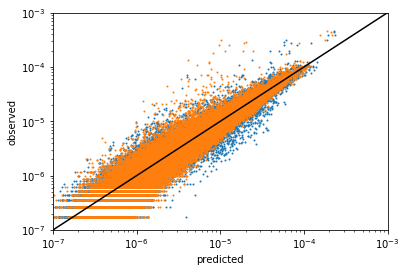

In [335]:
plt.scatter(tri, exp, s=1)
plt.scatter(ising, exp, s=1)
x = np.logspace(-7, -3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot(x, x, 'k')
plt.xlim(min(x), max(x))
plt.ylim(min(x), max(x))
plt.xscale('log')
plt.yscale('log')